# 1. Data

In [1]:
from keras.datasets import mnist

In [2]:
(train_x, train_y) , (test_x, test_y) = mnist.load_data()

In [3]:
train_x.shape

(60000, 28, 28)

In [4]:
from matplotlib import pyplot as plt

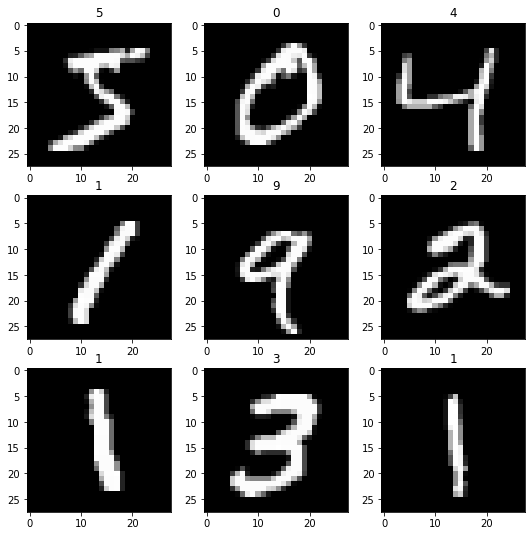

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(9,9))
for i in range(9):
    row = i//3
    column = i%3
    axs[row][column].imshow(train_x[i], cmap="gray")
    axs[row][column].set_title(train_y[i])
plt.show()

# 2. Preprocess data

In [6]:
# Adds a new dimension. This is the depth of image
import numpy as np
train_x = np.expand_dims(train_x, axis=1)
test_x = np.expand_dims(test_x, axis=1)

In [7]:
train_x = train_x/255.0
test_x = test_x/255.0

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Split the dataset. Random_state is seed
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [10]:
import torch

In [11]:
class Data(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.x = data
        self.y = label

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [12]:
train, val = Data(train_x, train_y), Data(val_x, val_y)

In [13]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=32)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=32)

# 3. Build model

In [14]:
from torch import nn


class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(28*28, 32)
        # 10 is out_feature, corresponds to digits 0->9
        # 28 is size of dataset
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)  # Stretch array of 28*28 to 1*724
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x


In [15]:
# New model of lesson 3
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Kernel_size: size of filter block
        # Stride: The distance between position of the filter
        # Padding: Non-sense at border, so that all data is preserved 
        # (in case there is remainder when dividing by kernel_size or something)

        # 28x28x1 -> 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 13x13x32 -> 13x13x64
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        # 6x6x64
        self.linear1 = nn.Linear(6*6*64, 32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, 10)
    
    def forward(self, x):
        # Go through all layers
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# 4. Train

In [16]:
model = SimpleCNN()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model = model.to(device)
criterion = criterion.to(device)


In [17]:
from tqdm import tqdm
min_val_loss = 100000000000
for epoch in range(10):
    total_loss_train = 0
    total_acc_train = 0
    for x, y in tqdm(train_dataloader):
        x = x.to(device)
        y = y.to(device)

        # Delete extra dimensions
        y = y.squeeze()

        output = model(x.float())

        batch_loss = criterion(output, y)
        total_loss_train += batch_loss

        acc = (output.argmax(dim=1) == y).sum().item()
        total_acc_train += acc

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_loss_val = 0
    total_acc_val = 0
    with torch.no_grad():  # Not training
        for x, y in tqdm(val_dataloader):
            x = x.to(device)
            y = y.to(device)

            # Delete extra dimensions
            y = y.squeeze()

            output = model(x.float())

            batch_loss = criterion(output, y)
            total_loss_val += batch_loss.item()

            acc = (output.argmax(dim=1) == y).sum().item()
            total_acc_val += acc
    print(
        f'''Epochs: {epoch+1} 
        | Train Loss: {total_loss_train / len(train):.3f}
        | Train Accuracy: {total_acc_train/len(train):.3f}
        | Val Loss: {total_loss_val/len(val):.3f}
        | Val Accuracy: {total_acc_val/len(val):.3f}'''
    )
    if min_val_loss > total_loss_val/len(val):
        min_val_loss = total_loss_val/len(val)
        torch.save(model.state_dict(), "simplecnn.pt")
        print(f"Save model because val loss improve loss {min_val_loss:.3f}")


100%|██████████| 375/375 [00:00<00:00, 722.55it/s]


Epochs: 1 
        | Train Loss: 0.009
        | Train Accuracy: 0.913
        | Val Loss: 0.005
        | Val Accuracy: 0.957
Save model because val loss improve loss 0.005


100%|██████████| 375/375 [00:00<00:00, 731.00it/s]


Epochs: 2 
        | Train Loss: 0.003
        | Train Accuracy: 0.966
        | Val Loss: 0.003
        | Val Accuracy: 0.973
Save model because val loss improve loss 0.003


100%|██████████| 375/375 [00:00<00:00, 718.39it/s]


Epochs: 3 
        | Train Loss: 0.002
        | Train Accuracy: 0.977
        | Val Loss: 0.002
        | Val Accuracy: 0.979
Save model because val loss improve loss 0.002


100%|██████████| 375/375 [00:00<00:00, 721.15it/s]


Epochs: 4 
        | Train Loss: 0.002
        | Train Accuracy: 0.982
        | Val Loss: 0.002
        | Val Accuracy: 0.983
Save model because val loss improve loss 0.002


100%|██████████| 375/375 [00:00<00:00, 735.29it/s]


Epochs: 5 
        | Train Loss: 0.002
        | Train Accuracy: 0.984
        | Val Loss: 0.002
        | Val Accuracy: 0.983
Save model because val loss improve loss 0.002


100%|██████████| 375/375 [00:00<00:00, 718.39it/s]


Epochs: 6 
        | Train Loss: 0.001
        | Train Accuracy: 0.988
        | Val Loss: 0.002
        | Val Accuracy: 0.984
Save model because val loss improve loss 0.002


100%|██████████| 375/375 [00:00<00:00, 710.23it/s]


Epochs: 7 
        | Train Loss: 0.001
        | Train Accuracy: 0.988
        | Val Loss: 0.002
        | Val Accuracy: 0.984


100%|██████████| 375/375 [00:00<00:00, 700.93it/s]


Epochs: 8 
        | Train Loss: 0.001
        | Train Accuracy: 0.990
        | Val Loss: 0.002
        | Val Accuracy: 0.983


100%|██████████| 375/375 [00:00<00:00, 695.73it/s]


Epochs: 9 
        | Train Loss: 0.001
        | Train Accuracy: 0.991
        | Val Loss: 0.002
        | Val Accuracy: 0.985


100%|██████████| 375/375 [00:00<00:00, 690.61it/s]

Epochs: 10 
        | Train Loss: 0.001
        | Train Accuracy: 0.991
        | Val Loss: 0.002
        | Val Accuracy: 0.982


# 5. Tests

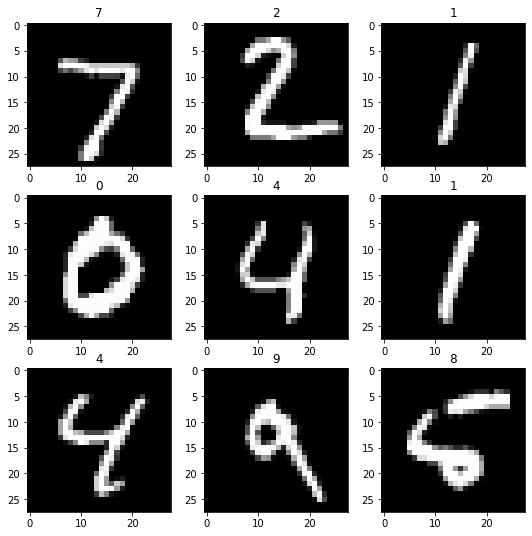

In [18]:
model = SimpleCNN()
model = model.to(device)
model.load_state_dict(torch.load("simplecnn.pt"))

test_x =torch.tensor(test_x).to(device)
test_y = torch.tensor(test_y).to(device)

(model(test_x.float()).argmax(dim=1)==test_y).sum().item()/test_y.shape[0]

fig, axs = plt.subplots(3, 3, figsize=(9,9))
for i in range(9):
  row = i//3
  column = i%3
  
  axs[row][column].imshow(test_x[i].squeeze().cpu(), cmap="gray")
  axs[row][column].set_title(model(test_x[i:i+1].float()).argmax(dim=1)[0].item())
plt.show()